**1)** **Configuración del ambiente**:


In [1]:
#Importamos librerías a utilizar.
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import requests
import re

#Definimos variables globales:
df_bitcoin = None
precio_actual = None
tendencia= None
media_bitcoin= None
algoritmo_decision=None



**2A)Obtencion de datos Primera parte:**

In [2]:
# Utilizamos la biblioteca yfinance de Python para extraer el histórico de precios del Bitcoin en dólares BTC-USD,
# y extraer el histórico de los últimos 7 días en intervalos de 5 minutos.
#Primera parte:

def importar_base_bitcoin():
  global df_bitcoin
    # Definir el símbolo del Bitcoin en Yahoo Finance
  symbol = "BTC-USD"

  # Obtener la fecha y hora actual
  end_date = datetime.now()

  # Calcular la fecha y hora de inicio (7 días atrás)
  start_date = end_date - timedelta(days=7)

  # Convertir las fechas a formato aceptado por yfinance
  start_date_str = start_date.strftime("%Y-%m-%d")
  end_date_str = end_date.strftime("%Y-%m-%d")

  # Descargar el histórico de precios con intervalo de 5 minutos
  df_bitcoin = yf.download(symbol, start=start_date_str, end=end_date_str, interval="5m")
  return df_bitcoin
df_bitcoin=importar_base_bitcoin()
print(df_bitcoin)


[*********************100%%**********************]  1 of 1 completed
                                   Open          High           Low  \
Datetime                                                              
2023-10-13 00:00:00+00:00  26752.878906  26755.128906  26748.310547   
2023-10-13 00:05:00+00:00  26752.611328  26759.220703  26751.503906   
2023-10-13 00:10:00+00:00  26781.531250  26781.531250  26771.378906   
2023-10-13 00:15:00+00:00  26794.029297  26835.029297  26794.029297   
2023-10-13 00:20:00+00:00  26816.103516  26833.380859  26816.103516   
...                                 ...           ...           ...   
2023-10-19 23:35:00+00:00  28677.333984  28677.333984  28663.396484   
2023-10-19 23:40:00+00:00  28661.525391  28664.634766  28657.626953   
2023-10-19 23:45:00+00:00  28677.605469  28695.470703  28677.605469   
2023-10-19 23:50:00+00:00  28695.728516  28713.220703  28695.728516   
2023-10-19 23:55:00+00:00  28711.353516  28718.220703  28708.873047   

       

**2B)Obtencion de datos Segunda parte**

In [5]:
#Segunda parte de Obtencion de datos, usamos técnica Scraping para obtner valor actal del BTC vs US
#y su tendencia de su precio (subida o bajada), dentro de la última hora.


def extraer_tendencia():
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36'}
    url = "https://coinmarketcap.com/"
    respuesta = requests.get(url, headers=headers)
    s = BeautifulSoup(respuesta.content, features="lxml")
    buscando_tendencia = s.find("span", {"class": "sc-d55c02b-0 gUnzUB"})
    span_element = buscando_tendencia.find('span')

    # Verificar si la clase "icon-Caret-down" está presente en la etiqueta
    if span_element and 'icon-Caret-up' in span_element['class']:
        tendencia = "Baja"
    elif span_element and 'icon-Caret-down' in span_element['class']:
        tendencia = "Alta"
    else:
        tendencia = "Desconocida"

    # En esta parte Extraemos el precio actual.
    codigo_extraido = s.find('div', {"class": "sc-a0353bbc-0 gDrtaY"})
    texto_etiqueta = codigo_extraido.text

    # Utilizar expresiones regulares para encontrar el valor después del símbolo "$"
    patron = re.compile(r'\$(\d{1,3}(?:,\d{3})*(?:\.\d{2})?)')
    coincidencias = patron.search(texto_etiqueta)

    # Verificar si se encontraron coincidencias y obtener el valor
    if coincidencias:
        valor_despues_del_dolar = coincidencias.group(1)

        # Eliminar las comas y convertir a float
        precio_actual = float(valor_despues_del_dolar.replace(',', ''))

    else:
        print("No se encontró un valor después del símbolo $.")
        precio_actual = None  # Si no hay valor, asignar None

    return tendencia, precio_actual

# Llamada a la función y asignación de los valores devueltos
tendencia, precio_actual = extraer_tendencia()

print(tendencia)
print(precio_actual)




Alta
29616.66


**3)Limpieza de Datos.**

El DataFrame no tiene índices duplicados.
Registros eliminados como outliers: 512
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 512 entries, 2023-10-13 12:55:00+00:00 to 2023-10-19 11:50:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       512 non-null    float64
 1   High       512 non-null    float64
 2   Low        512 non-null    float64
 3   Close      512 non-null    float64
 4   Adj Close  512 non-null    float64
 5   Volume     512 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 28.0 KB
None
27848.357860565186


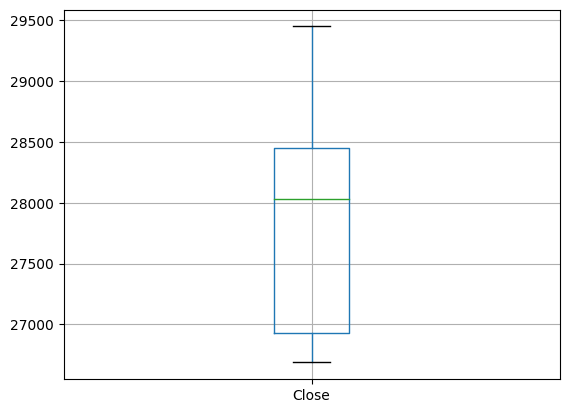

In [8]:
def limpieza_datos():
    df_bitcoin_limpio = df_bitcoin.copy()

    indices_duplicados = df_bitcoin_limpio.index.duplicated().any()
    if indices_duplicados:
        df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]
        print("El DataFrame tiene índices duplicados.")
    else:
        print("El DataFrame no tiene índices duplicados.")

    # Se aplica dropna y se asigna el resultado al DataFrame
    df_bitcoin_limpio["Close"].dropna(inplace=True)

    # Se filtra el DataFrame usando la condición de 'Volume' != 0
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] != 0]

    df_bitcoin_limpio.boxplot(["Close"])

    Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
    Q3 = df_bitcoin_limpio['Close'].quantile(0.75)

    # Filtrar el DataFrame para incluir solo los registros dentro del rango definido
    df_bitcoin_sin_outliers = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= Q1) & (df_bitcoin_limpio['Close'] <= Q3)]

    # Imprimir el número de registros eliminados como outliers
    registros_eliminados = len(df_bitcoin_limpio) - len(df_bitcoin_sin_outliers)
    print(f"Registros eliminados como outliers: {registros_eliminados}")

    media_bitcoin = df_bitcoin_sin_outliers['Close'].mean()

    # Se asigna el DataFrame filtrado de nuevo a df_bitcoin_limpio
    df_bitcoin_limpio = df_bitcoin_sin_outliers

    return df_bitcoin_limpio, media_bitcoin

df_bitcoin_limpio, media_bitcoin = limpieza_datos()

print(df_bitcoin_limpio.info())
print(media_bitcoin)


In [9]:
print(media_bitcoin)

27848.357860565186


**Gráfico después del tratamiento de datos:**

<Axes: >

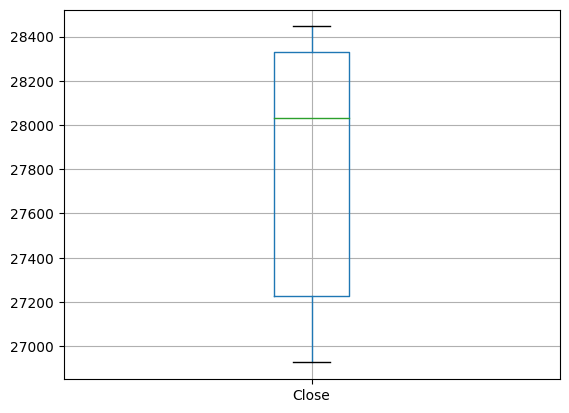

In [10]:
df_bitcoin_limpio.boxplot(["Close"])

**4)Tomar decisones:**


In [11]:
def tomar_decisiones(precio_actual,media_bitcoin,tendencia):
    if precio_actual >= media_bitcoin and tendencia == "Baja":
      algoritmo_decision = "Vender"
    elif precio_actual < media_bitcoin and tendencia == "Alta":
      algoritmo_decision = "Comprar"
    else:
      algoritmo_decision = "Esperar"
    print("Precio Promedio Bitcoin:",media_bitcoin)
    print("Precio Actual Bitcoin:",precio_actual)
    print("Tendencia:",tendencia)
    print("Decisión del algoritmo:",algoritmo_decision)
    return algoritmo_decision
decision= tomar_decisiones(precio_actual,media_bitcoin,tendencia)
print(decision)

Precio Promedio Bitcoin: 27848.357860565186
Precio Actual Bitcoin: 29616.66
Tendencia: Alta
Decisión del algoritmo: Esperar
Esperar


**5) Visalización:**

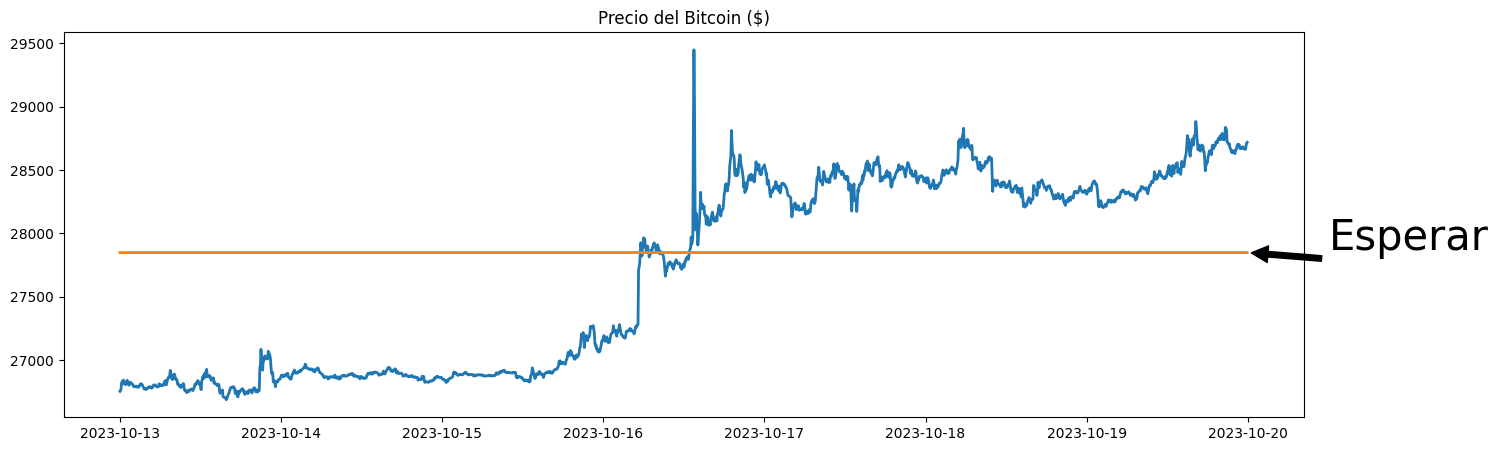

In [12]:
def visualizacion():
    global decision
    df_bitcoin["Promedio"] = media_bitcoin

    # Configurar el tamaño del gráfico en una proporción de 16x5
    plt.figure(figsize=(16, 5))

    # Agregar un título al gráfico
    plt.title('Precio del Bitcoin ($)')

    # Dibujar una línea con los datos del índice y la columna 'Close'
    plt.plot(df_bitcoin.index, df_bitcoin['Close'], label='Close', linewidth=2)

    # Dibujar una línea con los datos del índice y la columna 'Promedio'
    plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], label='Promedio', linewidth=2)

    # Utilizar annotate para mostrar el mensaje de decisión en el gráfico
    plt.annotate(decision, xy=(df_bitcoin.index[-1], df_bitcoin['Promedio'].iloc[-1]),
                 xytext=(df_bitcoin.index[-1] + pd.Timedelta(days=1), df_bitcoin['Promedio'].iloc[-1] + 20),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=30, ha='center')

    # Mostrar el gráfico
    plt.show()


    # Devolver el DataFrame modificado y el valor de decisión
    return df_bitcoin, decision

# Llamar a la función y asignar los resultados
df_bitcoin, decision = visualizacion()

**6)Automatización:**



In [14]:
from IPython.display import clear_output
import time

[*********************100%%**********************]  1 of 1 completed
El DataFrame no tiene índices duplicados.
Registros eliminados como outliers: 512
Precio Promedio Bitcoin: 27848.357860565186
Precio Actual Bitcoin: 29616.66
Tendencia: Alta
Decisión del algoritmo: Esperar


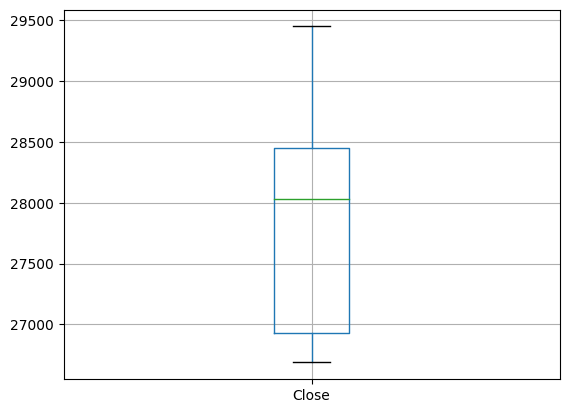

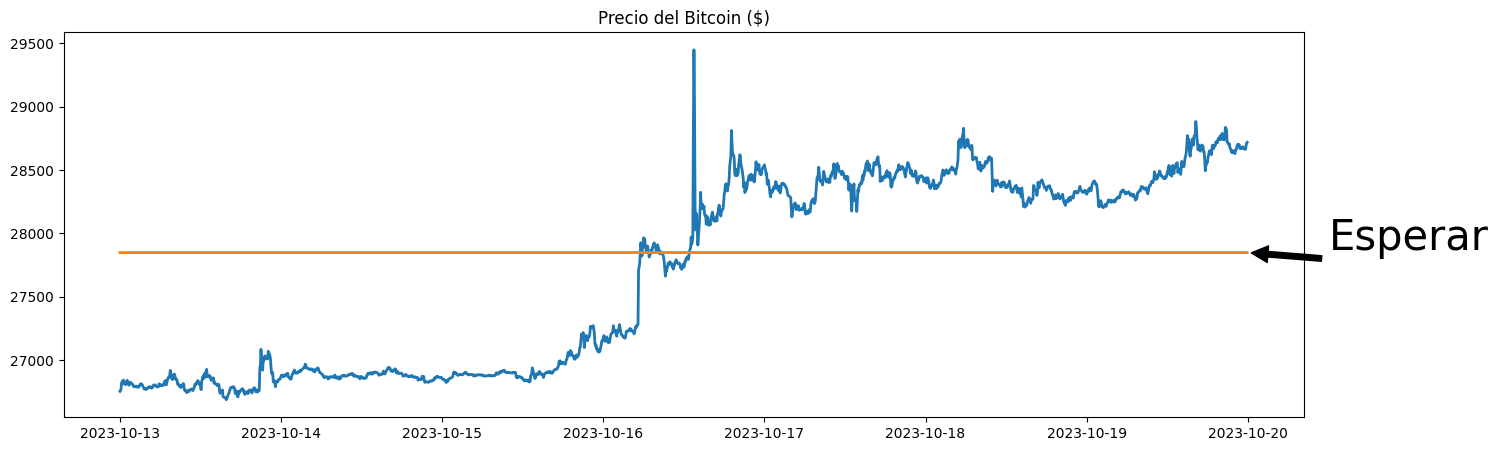

In [ ]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencia()
  limpieza_datos()
  tomar_decisiones(precio_actual,media_bitcoin,tendencia)
  visualizacion()
  time.sleep(300)

In [ ]:
print(precio_actual)

28314.91
